## object-detection ref : https://towardsdatascience.com/object-detection-with-less-than-10-lines-of-code-using-python-2d28eebc5b11

## color-extraction ref : https://code.likeagirl.io/finding-dominant-colour-on-an-image-b4e075f98097

In [2]:
import cv2
import matplotlib.pyplot as plt
import cvlib as cv
from cvlib.object_detection import draw_bbox

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import time
import numpy as np
from collections import Counter
import json

## 1. Load image file

>>> type of img     : <class 'numpy.ndarray'>
>>> size of matrix : (1350, 1080, 3)


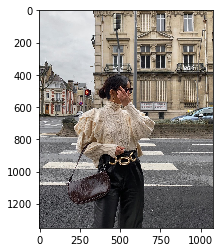

In [3]:
file_path = '../data/pictures_tissemrz/tissemrz_024_3116Likes.png'
img = cv2.imread(file_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(f'>>> type of img     : {type(img)}')
print(f'>>> size of matrix : {img.shape}')
plt.imshow(img)
plt.show()

## 2. Detect the object 'person' from image

In [4]:
bbox, label, conf = cv.detect_common_objects(img)
print('=== outputs ===')
print(f'bounding boxes    : {bbox}')  # x, y, x+width, y+height
print(f'detected objects  : {label}')
print(f'confidence levels : {conf}\n')

if label.count('person') > 1:   # Exceptional case : 2 or more persons are detected
    print('>>> Warning : More than 1 person is detected from the given picture!')
    idx = label.index('person')
    bbox = [bbox[idx]]
    label = [label[idx]]
    conf = [conf[idx]]
    
elif 'person' in label:   # Ideal case : only one main preson is detected
    idx = label.index('person')
    bbox = [bbox[idx]]
    label = [label[idx]]
    conf = [conf[idx]]
    
else:   # Exceptional case : No person is detected
    print('>>> Warning : No person is detected from the given picture!')

=== outputs ===
bounding boxes    : [[230, 362, 696, 1354], [808, 592, 1076, 694], [192, 934, 430, 1220], [283, 488, 319, 534]]
detected objects  : ['person', 'car', 'handbag', 'traffic light']
confidence levels : [0.9996593594551086, 0.9793494343757629, 0.9627959132194519, 0.8630921244621277]



## 3. Extract dominant colors of detected area (foreground)

#### 3-1. Preprocess image

In [0]:
# crop the detected area of image
img = img[bbox[0][1]:bbox[0][3], bbox[0][0]:bbox[0][2]]

#represent as row*column,channel number (appropriate format for KMeans)
img_reshape = img.reshape((img.shape[0] * img.shape[1], 3))

#### 3-2. Extract color

In [6]:
# arrange the cluster_centers of KMeans output according to frequency of each label
def arrange_cluster_centers(KMeans_obj):
    lb_counts = Counter(KMeans_obj.labels_)
    
    tmp_dict = {}
    for idx, pixel in enumerate(KMeans_obj.cluster_centers_):
        tmp_dict[ lb_counts[idx] ] = pixel  # { frequency of label : color of label } mapping
    
    centers_aranged_dict = dict(sorted(tmp_dict.items(), reverse=True))  # arrange the dict according to key (frequency of label)

    centers_aranged_arr = np.array(list(centers_aranged_dict.values()))  # pack colors into one array
    centers_aranged_arr = centers_aranged_arr.round().astype("uint8")  # tranform the type to integer
    centers_aranged_arr = np.expand_dims(centers_aranged_arr, 0)  # add one dimension for visualization
    return centers_aranged_arr


# arrange the components of DBSCAN output according to frequency of each label
def arrange_components(DBSCAN_obj):
    lb_counts = Counter(DBSCAN_obj.labels_)
    
    tmp_dict = {}
    uniq_components = np.unique(clt_DBSCAN.components_, axis=0)
    for idx, pixel in enumerate(uniq_components):
        tmp_dict[ lb_counts[idx] ] = pixel  # { frequency of label : color of label } mapping
    
    components_aranged_dict = dict(sorted(tmp_dict.items(), reverse=True))  # arrange the dict according to key (frequency of label)

    components_aranged_arr = np.array(list(components_aranged_dict.values()))  # pack colors into one array
    components_aranged_arr = components_aranged_arr.round().astype("uint8")  # tranform the type to integer
    components_aranged_arr = np.expand_dims(components_aranged_arr, 0)  # add one dimension for visualization
    return components_aranged_arr


# Extract dominant color using KMeans
expected_num_col = 10  #cluster number
begin_time = time.time()
clt_KMeans = KMeans(n_clusters = expected_num_col)
clt_KMeans.fit(img_reshape)
end_time = time.time()
centers_aranged_arr = arrange_cluster_centers(clt_KMeans)
print(f'no of colors from KMeans : {centers_aranged_arr.shape[1]}')
print(f'time elapsed while training KMeans : {end_time - begin_time}')

# Extract dominant color using DBSCAN
begin_time = time.time()
clt_DBSCAN = DBSCAN(eps=0.2, min_samples=int(img_reshape.shape[0]/1000))
clt_DBSCAN.fit(img_reshape)
end_time = time.time()
components_arranged_arr = arrange_components(clt_DBSCAN)
print(f'no of colors from DBSCAN : {components_arranged_arr.shape[1]}')
print(f'time elapsed while training DBSCAN : {end_time - begin_time}')

no of colors from KMeans : 10
time elapsed while training KMeans : 16.06610655784607
no of colors from DBSCAN : 62
time elapsed while training DBSCAN : 8.797862529754639


#### 3-3. Visualize the ouputs

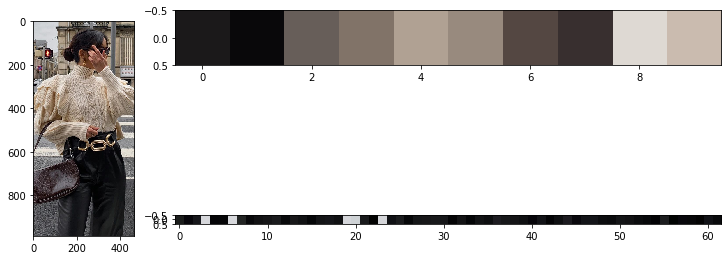

In [7]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
spec = fig.add_gridspec(2, 4)

axe1 = fig.add_subplot(spec[:, 0])
axe1.imshow(img)
axe2 = fig.add_subplot(spec[0, 1:])
axe2.imshow(centers_aranged_arr)
axe3 = fig.add_subplot(spec[1, 1:])
axe3.imshow(components_arranged_arr)

plt.show()